## The Cobweb Model

The cobweb model is a classic microeconomic framework used to explain price volatility in markets with production lags, such as agriculture. It assumes farmers form naive expectations, setting the expected price at time $ t $ as the previous period’s price $( p_t^* = p_{t-1} )$. The model is defined by the following equations (Enders, 2014, pp. 18–19):

- **Demand**: $ d_t = a - \gamma p_t $, where $ \gamma > 0 $ reflects price sensitivity.
- **Supply**: $ s_t = b + \beta p_{t-1} + \varepsilon_t $, where $ \beta > 0 $, and $ \varepsilon_t \sim N(0, \sigma^2) $ is a stochastic supply shock.
- **Market Clearing**: $ s_t = d_t $.

Combining these, the price dynamics follow a first-order difference equation (Enders, Eq. 1.39):

$$
p_t = \left(-\frac{\beta}{\gamma}\right) p_{t-1} + \frac{a-b}{\gamma} - \frac{\varepsilon_t}{\gamma}
$$

The long-run equilibrium price, when $ \varepsilon_t = 0 $ and $ p_t = p_{t-1} $, is:

$$
p = \frac{a-b}{\gamma+\beta}
$$

In [1]:
#using Pkg; Pkg.add(["Plots", "Distributions"])
using Plots, Distributions, Random

theme(:gruvbox_light)

In [2]:
struct CobwebParams
    a::Float64  # Demand intercept
    γ::Float64  # Demand slope coefficient
    b::Float64  # Supply intercept
    β::Float64  # Supply slope coefficient
    σ::Float64  # Standard deviation of supply shocks
end

In [3]:
demand(q, params) = (params.a - q) / params.γ   # Inverse demand function
supply(p_prev, params) = params.b + params.β * p_prev

supply (generic function with 1 method)

## Stability Condition

The stability of the cobweb model depends on the ratio $ \beta/\gamma $. The homogeneous part of the price equation is $ p_t = (-\beta/\gamma) p_{t-1} $, with solution $ p_t^h = A (-\beta/\gamma)^t $. The system converges to the equilibrium if the absolute value of the coefficient is less than 1 (Enders, 2014, p. 21):

$$
\left|-\frac{\beta}{\gamma}\right| = \frac{\beta}{\gamma} < 1
$$

- If $ \beta/\gamma < 1 $, oscillations dampen, and prices converge.
- If $ \beta/\gamma > 1 $, oscillations grow, leading to divergence.

We simulate both cases:
- **Stable**: $ \beta/\gamma = 0.5 $
- **Unstable**: $ \beta/\gamma = 2.0 $

In [4]:
function cobweb_simulate(params::CobwebParams, T::Int, p0::Float64, stoch::Bool=true)
    prices = zeros(T)
    quantities = zeros(T)
    shocks = zeros(T)

    prices[1] = p0
    quantities[1] = supply(p0, params) + shocks[1]

    if stoch
        shocks = rand(MersenneTwister(42), Normal(0, params.σ), T)
    end
    
    for t in 2:T
        quantities[t] = supply(prices[t-1], params) + shocks[t]
        prices[t] = demand(quantities[t], params)
    end

    return prices, quantities, shocks
end

cobweb_simulate (generic function with 2 methods)

In [ ]:
function cobweb_diagram(params::CobwebParams, p0::Float64, steps::Int)
    p_min, p_max = 0, 10
    p_range = range(p_min, p_max, length=100)
    
    q_demand = params.a .- params.γ * p_range
    q_supply = supply.(p_range, Ref(params))
    
    x_min = max(0, minimum(q_demand), minimum(q_supply))  # Ensure non-negative
    x_max = max(maximum(q_demand), maximum(q_supply))
    
    # Initialise cobweb path
    p_path = [p0]
    q_path = [supply(p0, params)]
    
    # Generate price/quantity path
    for _ in 1:steps
        p_new = demand(last(q_path), params)
        push!(p_path, p_new)
        push!(q_path, last(q_path))
        push!(p_path, p_new)
        push!(q_path, supply(p_new, params))
    end
    
    anim = @animate for i in 1:2*steps
        plot(q_demand, p_range, label="Demand", 
             xlabel="Quantity", ylabel="Price",
             title="Cobweb Diagram",
             xlims=(x_min, x_max), ylims=(p_min, p_max),
             dpi=300, legend=:topleft)
        
        plot!(q_supply, p_range, label="Supply")
        
        for j in 1:i
            plot!([q_path[j], q_path[j+1]], [p_path[j], p_path[j+1]], 
                  color=:red, label=(j == 1 ? "Path" : ""), linewidth=1.5)
        end
        
        scatter!(q_path[1:i+1], p_path[1:i+1], 
                 label="Steps", color=:black, markersize=3)
    end
    
    gif(anim, "images/cobweb-deterministic-$(params.β/params.γ).gif", fps=5)
end

cobweb_diagram (generic function with 1 method)

In [6]:
function equilibrium(params::CobwebParams)
    eq_price = (params.a - params.b) / (params.γ + params.β)
    eq_quantity = (params.a * params.β + params.γ * params.b) / (params.γ + params.β)

    return eq_price, eq_quantity
end

equilibrium (generic function with 1 method)

## Impulse Response Function (IRF)

The IRF measures the effect of a one-unit supply shock ($ \varepsilon_t $) on future prices. For the cobweb model, the IRF is derived from the price equation (Enders, Eq. 1.46, p. 22):

$$
\frac{\partial p_{t+j}}{\partial \varepsilon_t} = \left(-\frac{1}{\gamma}\right) \left(-\frac{\beta}{\gamma}\right)^j
$$

- In the stable case ($ \beta/\gamma < 1 $), the IRF oscillates and decays to zero.
- In the unstable case ($ \beta/\gamma > 1 $), the IRF oscillates with growing amplitude.

We compute the IRF over a horizon of 10 periods to analyze shock persistence.

In [7]:
function impulse_response(params::CobwebParams, horizon::Int)
    irf = zeros(horizon)

    for j in 0:horizon - 1
        irf[j+1] = (-1/params.γ) * (-params.β/params.γ)^j
    end
    
    return irf
end

impulse_response (generic function with 1 method)

## Simulation

In [8]:
params_stable = CobwebParams(10.0, 2.0, 2.0, 1.0, 0.1)  # β/γ = 0.5 < 1
params_unstable = CobwebParams(10.0, 1.0, 2.0, 2.0, 0.1)  # β/γ = 2.0 > 1

T = 50
p0 = 4.0
horizon = 10

10

### Stable Cases

#### Deterministic Model
- Prices and quantities oscillate and converge to the equilibrium $ (a-b)/(\gamma+\beta) \approx 2.67 $, as $ \beta/\gamma = 0.5 < 1 $.
- Price-quantity adjustments spiral inward to the equilibrium, visualised in the Cobweb diagram.

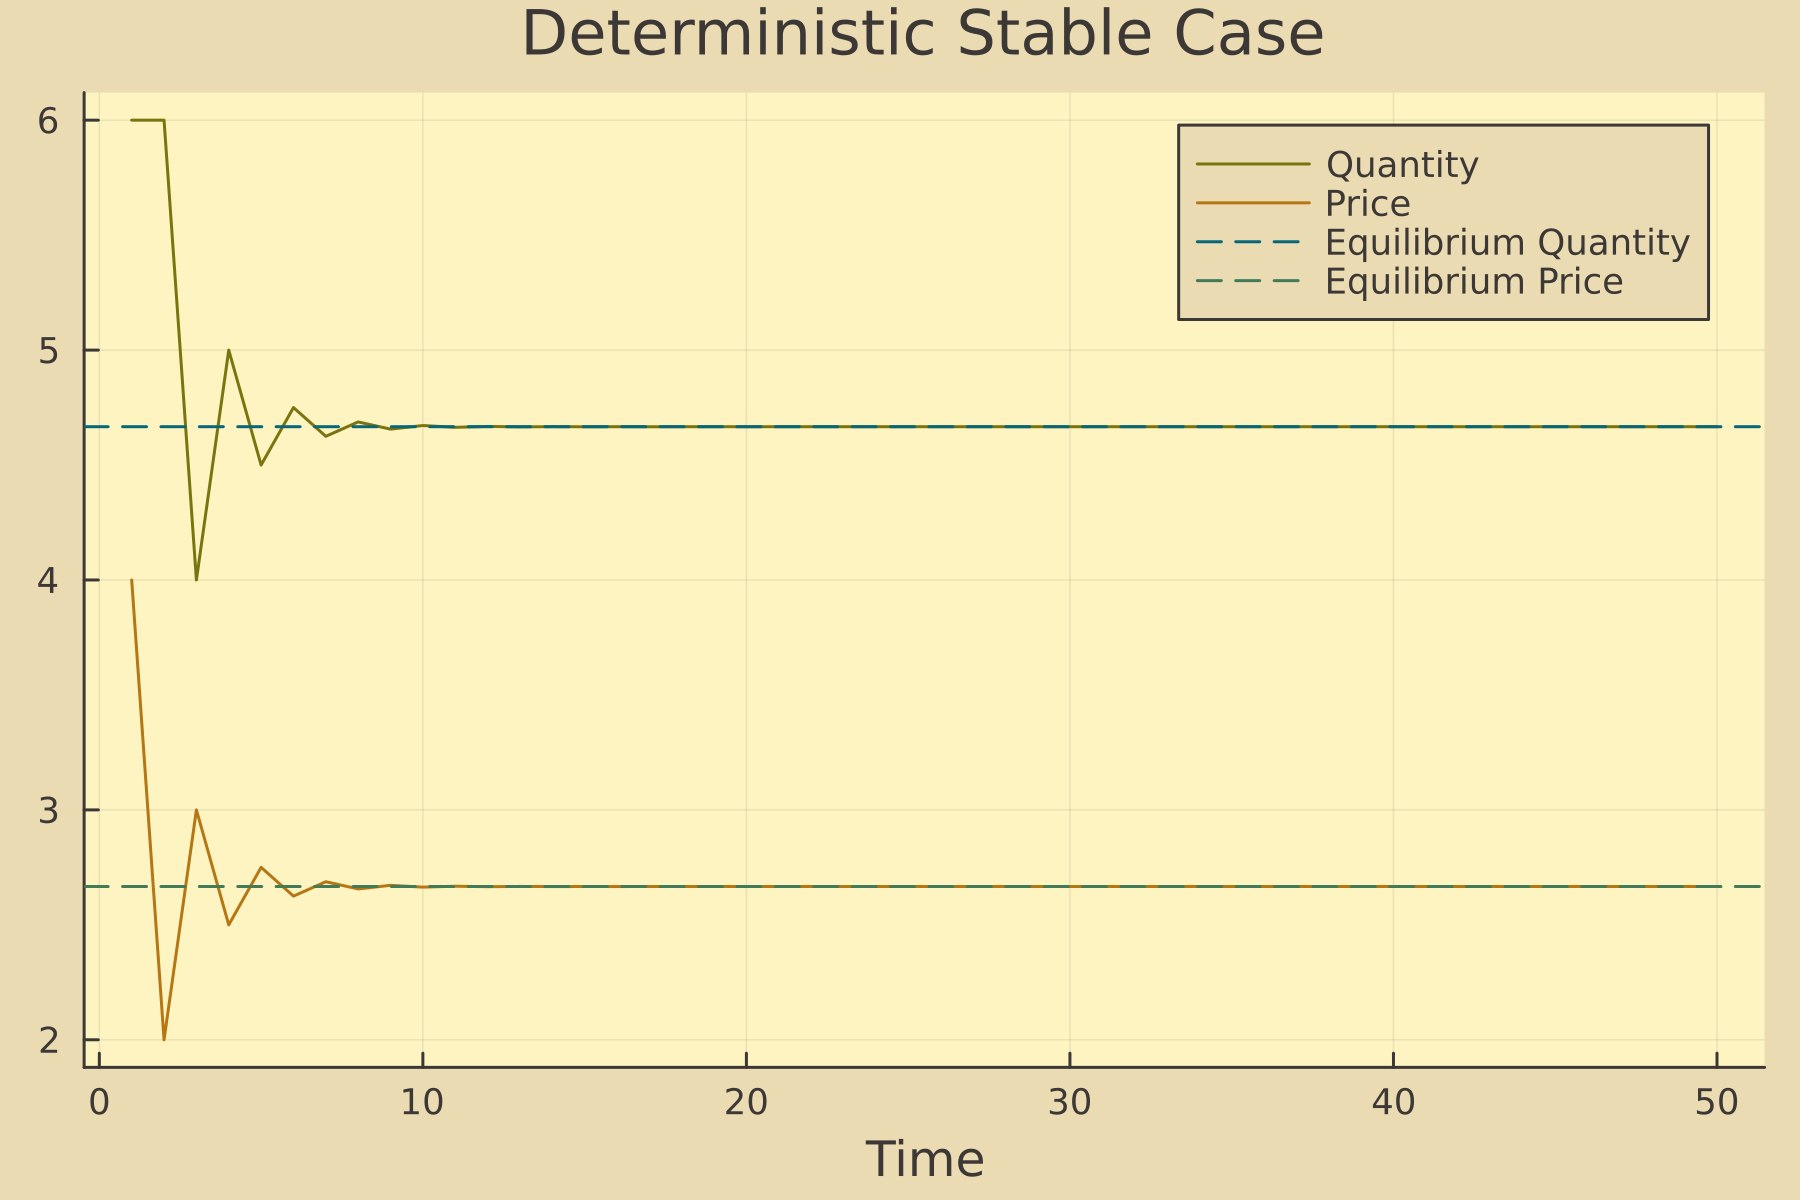

In [10]:
prices_det, quantities_det = cobweb_simulate(params_stable, T, p0, false)
eq_price, eq_quantity = equilibrium(params_stable)

p_det_stable = plot(1:T, quantities_det, label="Quantity", xlabel="Time", title="Deterministic Stable Case", dpi=300)
plot!(p_det_stable, 1:T, prices_det, label="Price")
hline!(p_det_stable, [eq_quantity], label="Equilibrium Quantity", linestyle=:dash)
hline!(p_det_stable, [eq_price], label="Equilibrium Price", linestyle=:dash)

┌ Info: Saved animation to d:\Development\Projects\stochastic-cobweb-model\images\cobweb-deterministic-0.5.gif
└ @ Plots C:\Users\ritob\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("d:\\Development\\Projects\\stochastic-cobweb-model\\images\\cobweb-deterministic-0.5.gif")
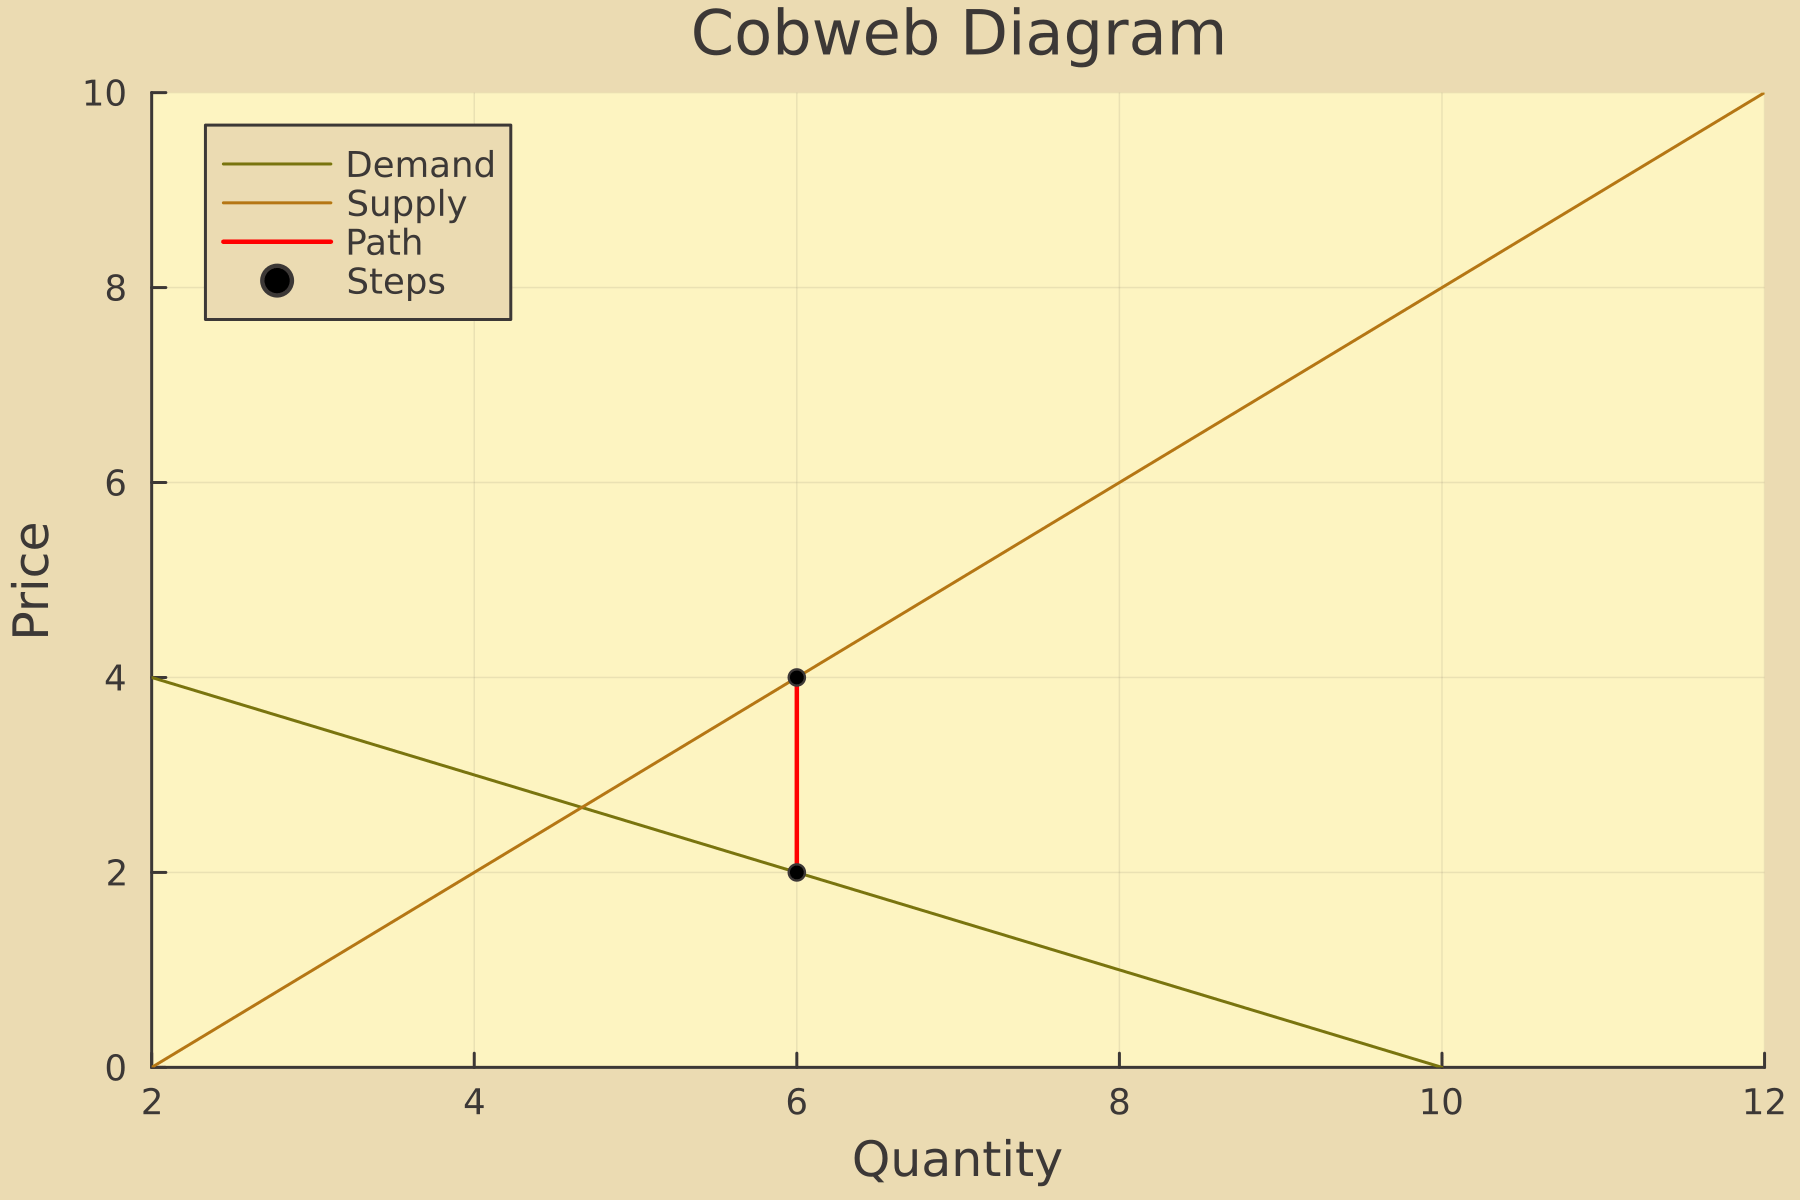

In [11]:
cobweb_diagram(params_stable, p0, 10)

#### Stochastic Model
- With shocks ($ \sigma = 0.1 $), prices fluctuate around the equilibrium ($ \approx 2.67 $), remaining bounded due to stability.
- The IRF shows price responses to a supply shock oscillating and decaying to zero, consistent with $ \beta/\gamma < 1 $.

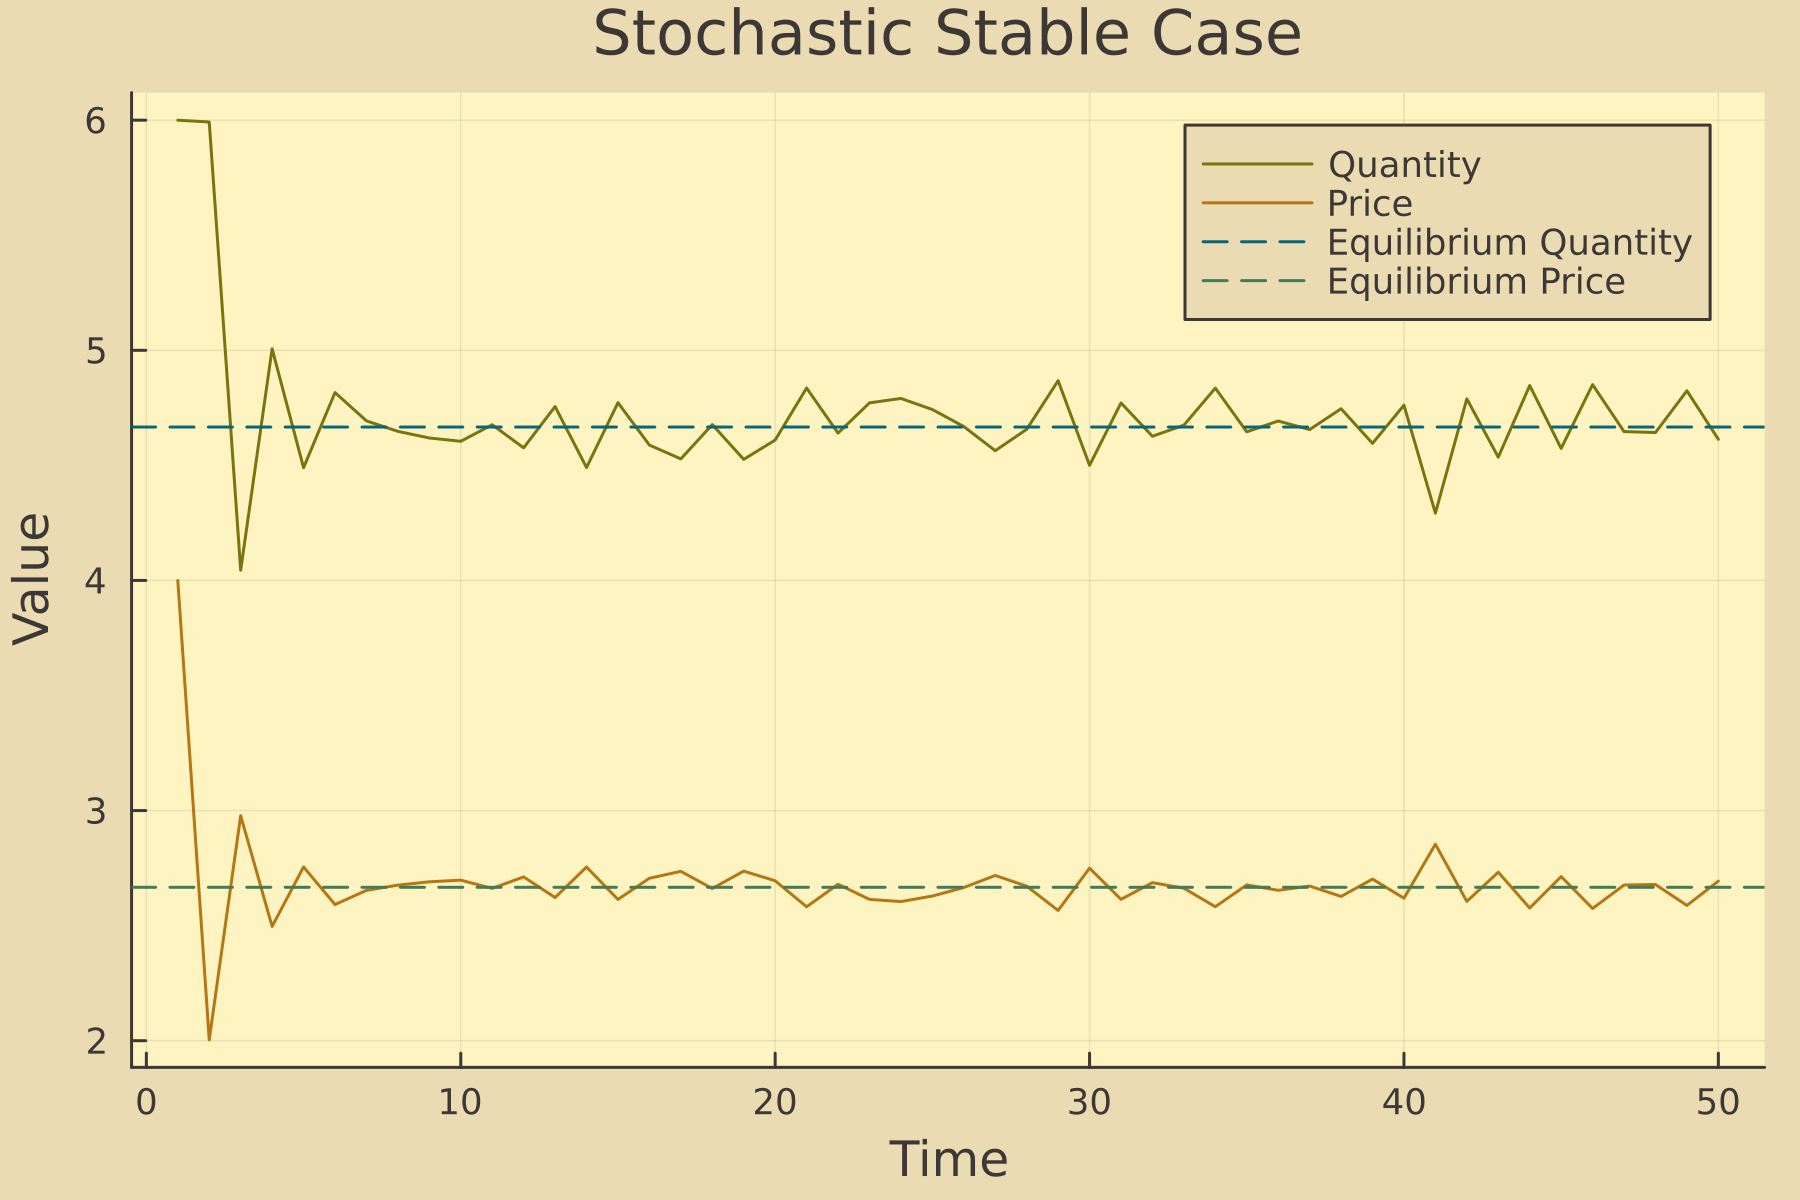

In [12]:
prices_stable, quantities_stable, shocks_stable = cobweb_simulate(params_stable, T, p0)

p_stoc_stable = plot(1:T, quantities_stable, label="Quantity", xlabel="Time", ylabel="Value", title="Stochastic Stable Case", dpi=300)
plot!(p_stoc_stable, 1:T, prices_stable, label="Price")
hline!(p_stoc_stable, [eq_quantity], label="Equilibrium Quantity", linestyle=:dash)
hline!(p_stoc_stable, [eq_price], label="Equilibrium Price", linestyle=:dash)

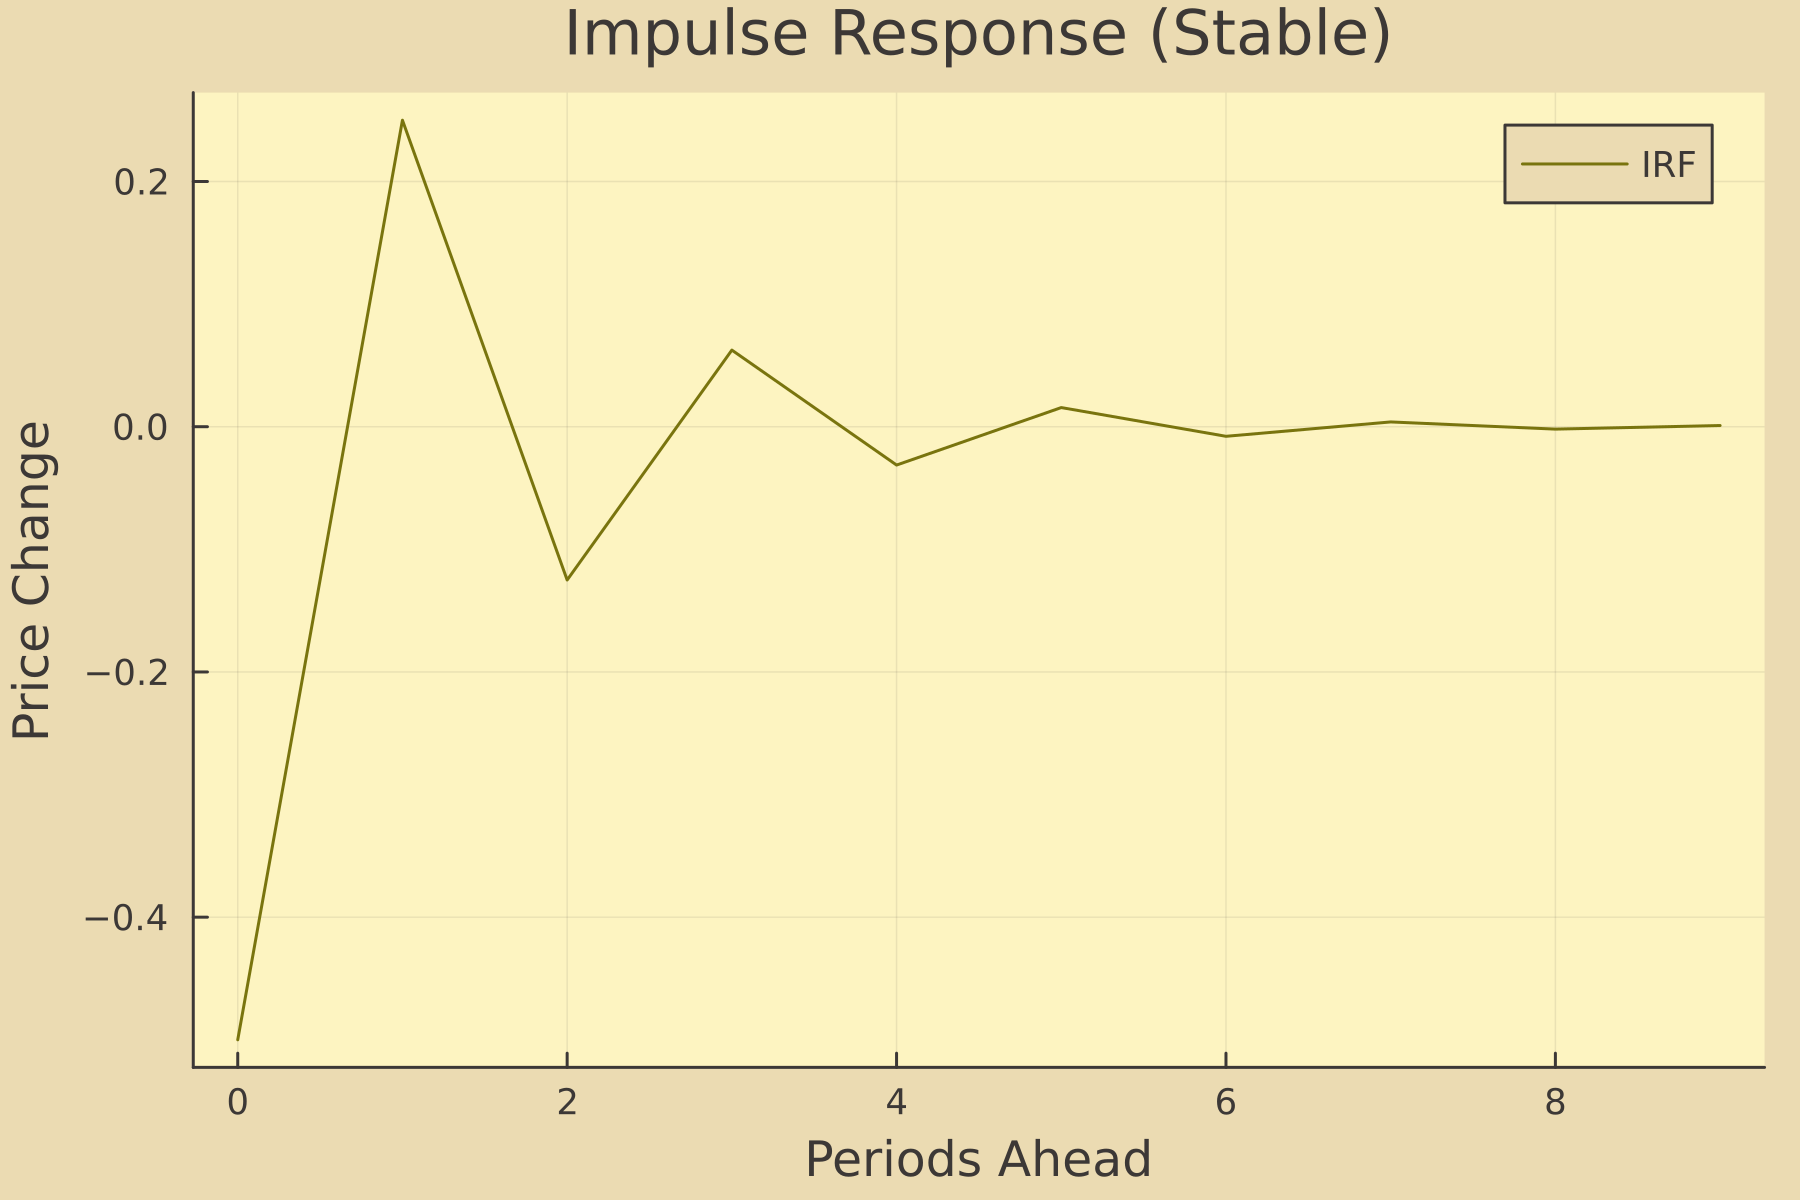

In [19]:
irf_stable = impulse_response(params_stable, horizon)
p_irf_stable = plot(0:horizon-1, irf_stable, label="IRF", xlabel="Periods Ahead", ylabel="Price Change", title="Impulse Response (Stable)", dpi=300)

### Unstable Cases

#### Deterministic Model
- Prices and quantities exhibit explosive oscillations, diverging from the equilibrium, since $ \beta/\gamma = 2.0 > 1 $.
- Price-quantity adjustments spiral outwards away from the equilibrium, visualised in the Cobweb diagram.

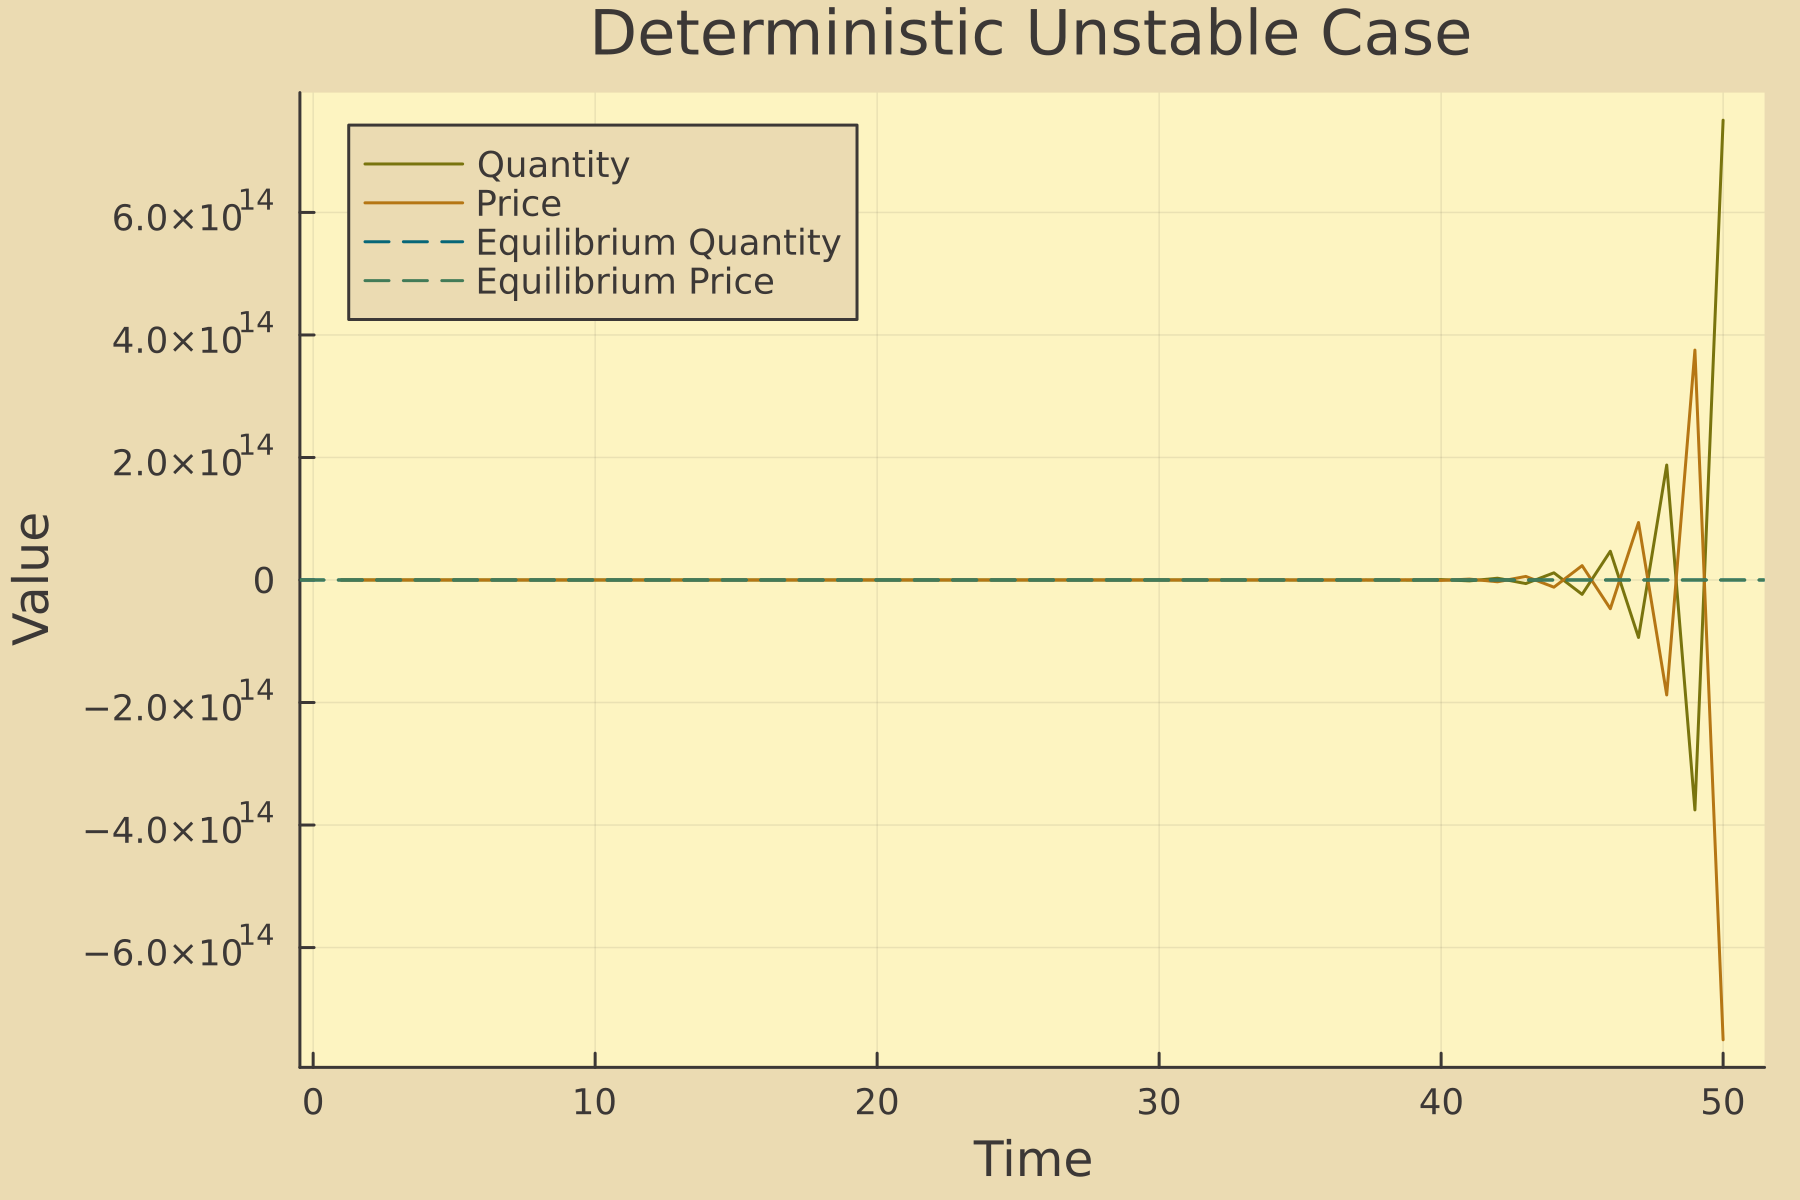

In [14]:
prices_det, quantities_det = cobweb_simulate(params_unstable, T, p0, false)
eq_price, eq_quantity = equilibrium(params_stable)

p_det_unstable = plot(1:T, quantities_det, label="Quantity", xlabel="Time", ylabel="Value", title="Deterministic Unstable Case", dpi=300)
plot!(p_det_unstable, 1:T, prices_det, label="Price")
hline!(p_det_unstable, [eq_quantity], label="Equilibrium Quantity", linestyle=:dash)
hline!(p_det_unstable, [eq_price], label="Equilibrium Price", linestyle=:dash)

┌ Info: Saved animation to d:\Development\Projects\stochastic-cobweb-model\images\cobweb-deterministic-2.0.gif
└ @ Plots C:\Users\ritob\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("d:\\Development\\Projects\\stochastic-cobweb-model\\images\\cobweb-deterministic-2.0.gif")
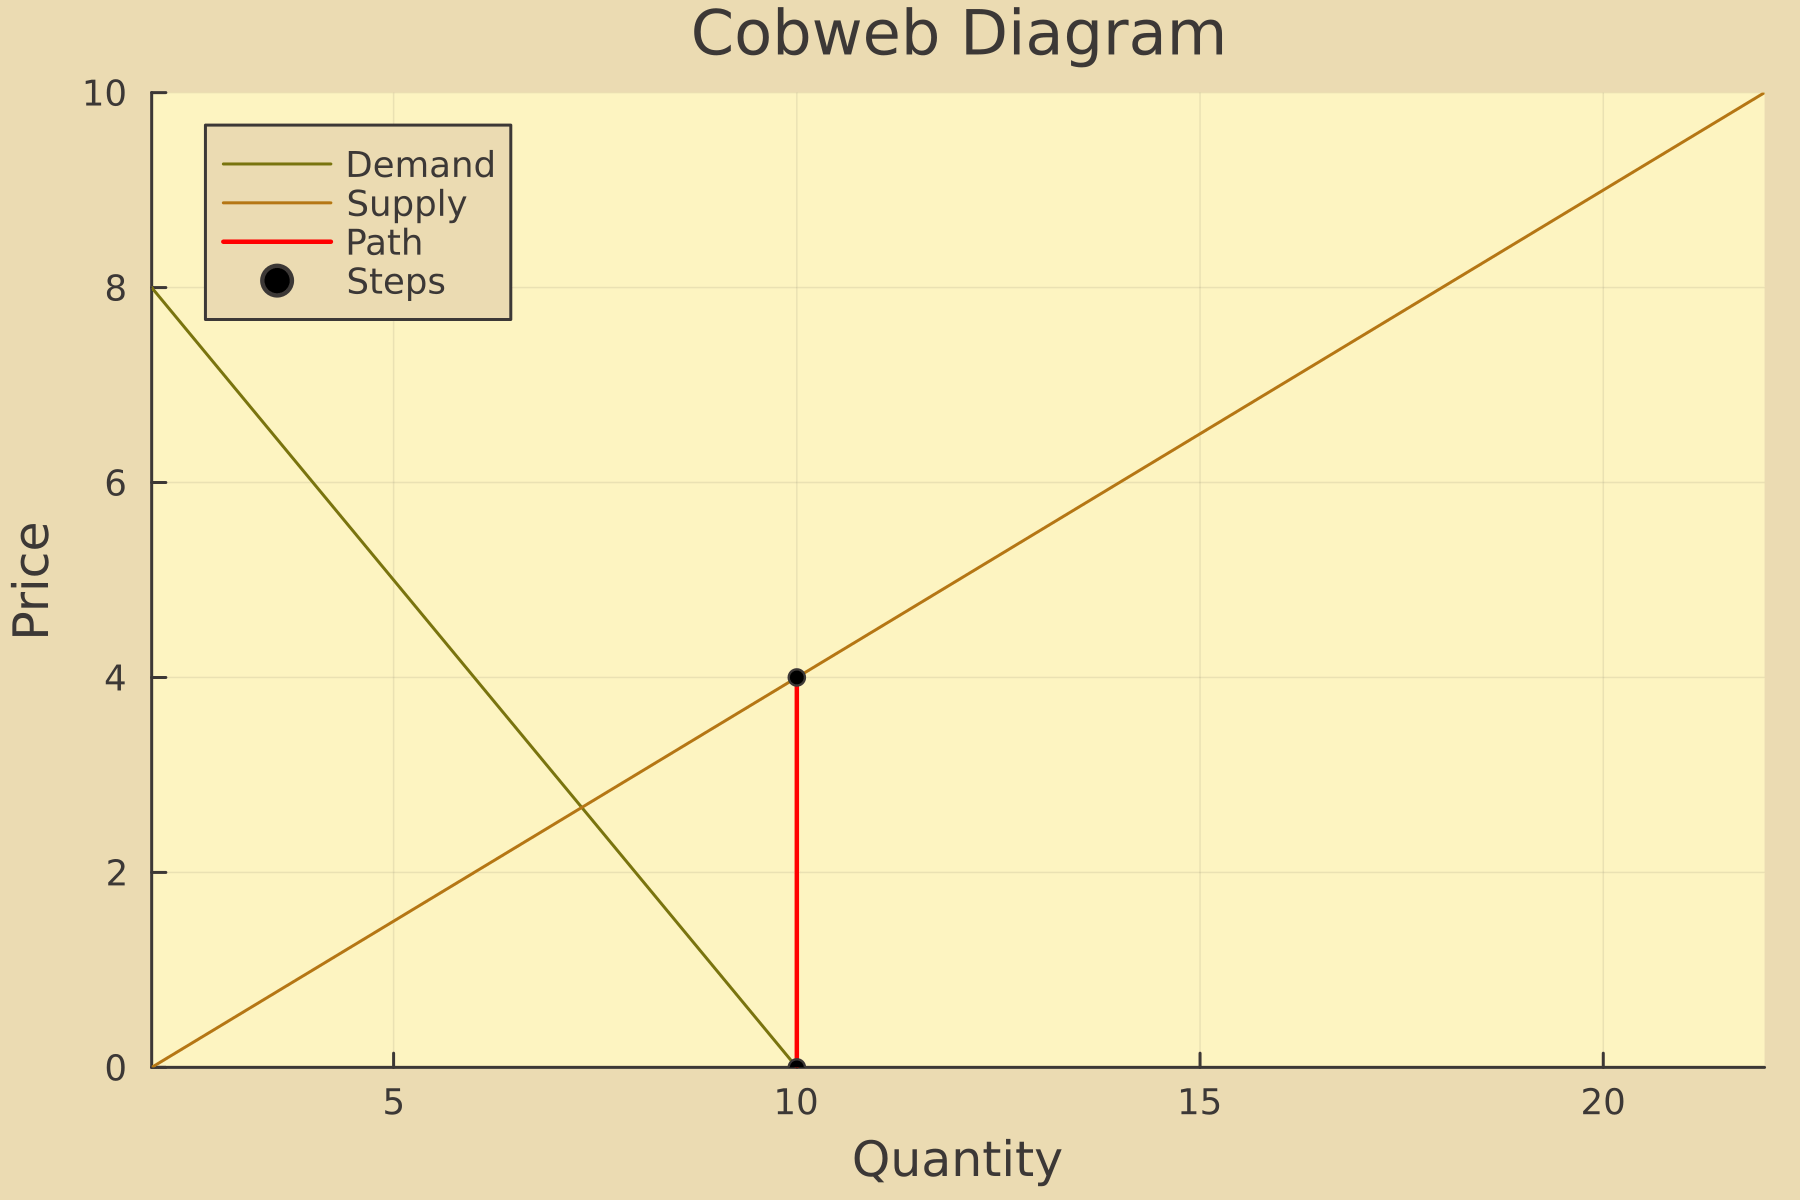

In [13]:
cobweb_diagram(params_unstable, p0, 10)

#### Stochashtic Model
- Prices diverge rapidly with shocks, as $ \beta/\gamma = 2.0 > 1 $, leading to unsustainable oscillations.
- The IRF shows price responses growing exponentially, reflecting the unstable dynamics of $ \beta/\gamma > 1 $.

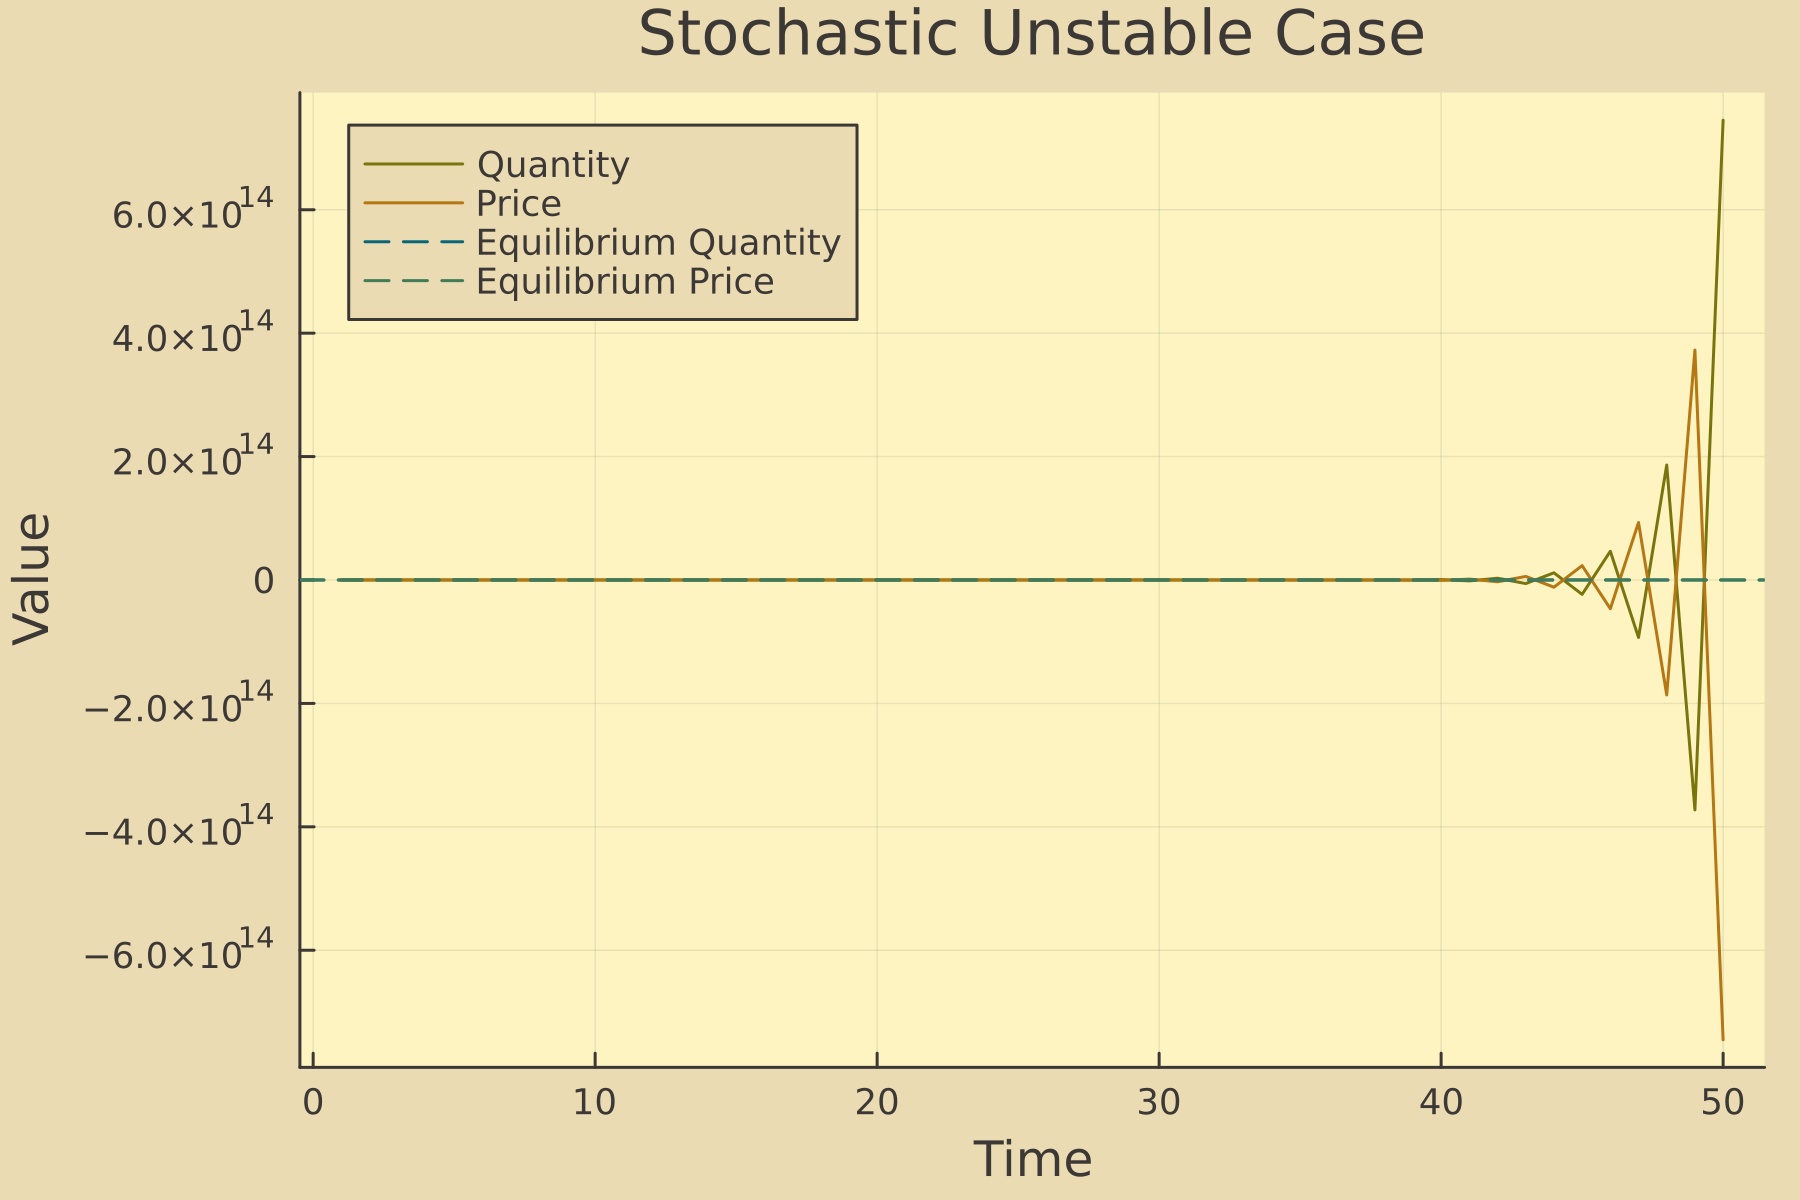

In [15]:
prices_unstable, quantities_unstable, shocks_unstable = cobweb_simulate(params_unstable, T, p0)
eq_price_unstable = (params_unstable.a - params_unstable.b) / (params_unstable.γ + params_unstable.β)

p_stoc_unstable = plot(1:T, quantities_unstable, label="Quantity", xlabel="Time", ylabel="Value", title="Stochastic Unstable Case", dpi=300)
plot!(p_stoc_unstable, 1:T, prices_unstable, label="Price")
hline!(p_stoc_unstable, [eq_quantity], label="Equilibrium Quantity", linestyle=:dash)
hline!(p_stoc_unstable, [eq_price_unstable], label="Equilibrium Price", linestyle=:dash)

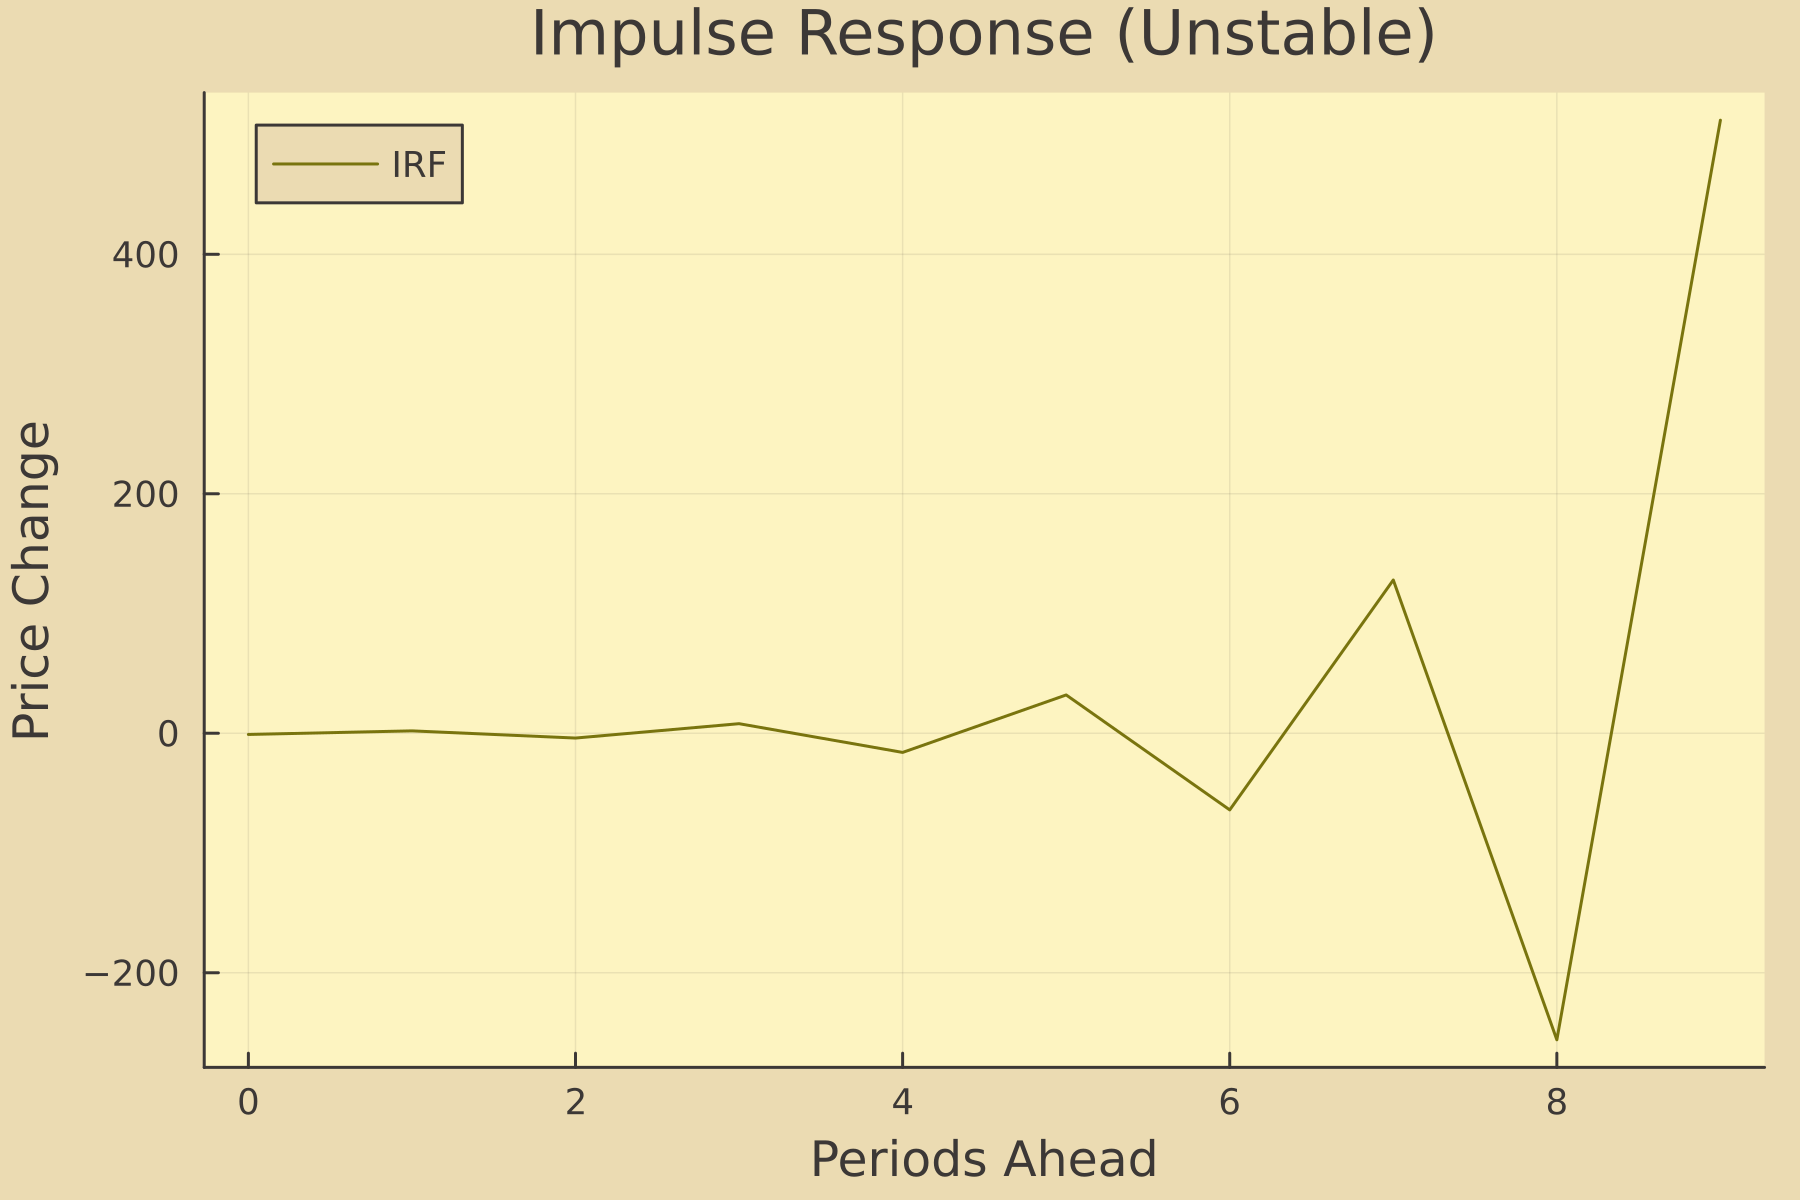

In [16]:
irf_unstable = impulse_response(params_unstable, horizon)
p_irf_unstable = plot(0:horizon-1, irf_unstable, label="IRF", xlabel="Periods Ahead", ylabel="Price Change", title="Impulse Response (Unstable)", dpi=300)

## References
- Enders, Walter. *Applied Econometric Time Series*. 4th ed., Wiley, 2014, pp. 18–22.

## Misc.

In [20]:
savefig(p_det_stable, "images/path-deterministic-stable.png");
savefig(p_det_unstable, "images/path-deterministic-unstable.png");
savefig(p_stoc_stable, "images/path-stochastic-stable.png");
savefig(p_stoc_unstable, "images/path-stochastic-unstable.png");
savefig(p_irf_stable, "images/irf-stable.png");
savefig(p_irf_unstable, "images/irf-unstable.png");